<a href="https://colab.research.google.com/github/KimJisanER/medical_ai/blob/main/%5Bopen%5D_03_lowbp_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 의료인공지능 전문가 양성과정 2022
## VitalDB Tutorial <br> Low blood pressure prediction using arterial wave - model building
- Date : Sep. 03, 2022
- Author : **Hyun-Lim Yang, Ph.D.**<br>
Research Assistant Professor @
Seoul National University Hospital <br>
Department of Anesthesiology and Pain Medicine
- E-mail : hlyang{_at_}snu{_dot_}ac{_dot_}kr
***

In [1]:
from IPython.display import HTML
style_warn = "<style>div.warn { background-color: #fcf2f2;border-color: #dFb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;}</style>"
HTML(style_warn)

### Import packages

> **Wargning** <br>
> colab 환경을 위한 google drive import 코드가 포함되어 있습니다. <br>
> 로컬 환경에서 실행 시 colab을 위한 import function들을 comment out 한 뒤 실행하세요. 

In [2]:
from google.colab import drive  # for colab
drive.mount('/content/gdrive/')  # for colab

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import os
cloud_directory = '/content/gdrive/My Drive/KOHI_2022_CNN_data_open/'
os.listdir(cloud_directory) # for colab, check cloud directory mount

['kohi_preprocessor.py',
 'sample_csv',
 'datasets',
 '__init__.py',
 '__pycache__',
 'kohi_CNN_model_archi.png']

In [4]:
import sys
# download_directory = os.getcwd() # for local environments
# sys.path.append(download_directory) # for local environments
sys.path.append(cloud_directory) # for colab

In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import keras
import glob
import kohi_preprocessor as pre
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings(action='ignore')

download_directory = cloud_directory # for colab

<div class="warn">**Warning!** : use your directory at `download_directory`</div>


### Data loading
사전에 구축된 데이터셋 로드

In [6]:
with open('{}/datasets/lowbp_alines_1min_delay_20sec_compressed.np'.format(download_directory), 'rb') as f:
    aline_data = pickle.load(f)
    
with open('{}/datasets/lowbp_ylabels_1min_delay_20sec_compressed.np'.format(download_directory), 'rb') as f:
    ylabel_data = pickle.load(f)
    
with open('{}/datasets/lowbp_charts_1min_delay_20sec_compressed.np'.format(download_directory), 'rb') as f:
    charts_data = pickle.load(f)
    
#with open('{}/datasets/lowbp_mbps_1min_delay_20sec_compressed.np'.format(download_directory), 'rb') as f:
#    mbps_data = pickle.load(f)

### Train data와 Valid 데이터로 데이터 구분
편의를 위해 여기선 85번 차트 이후의 데이터를 모두 validation으로 구분
> **TODO:** `aline_data`와 `ylabel_data`를 각각 train set 과 validation set으로 구분하여 `aline_train`, `aline_valid`, `ylabel_train`, `ylabel_valid`로 저장

In [7]:
### =========== Your code here ====================


test_index = (charts_data > '00085.csv')
train_index = ~test_index


aline_train = aline_data[train_index]
ylabel_train = ylabel_data[train_index]

aline_test = aline_data[test_index]
ylabel_test = ylabel_data[test_index]

### ===============================================

train 데이터에서 저혈압 데이터 비율

In [8]:
ylabel_train.sum() / len(ylabel_train)

0.1856234392241129

Valid 데이터에서 저혈압 데이터 비율


In [9]:
ylabel_test.sum() / len(ylabel_test)

0.1848213509519256

### Model building에 필요한 패키지 불러오기

In [10]:
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import Input, concatenate, multiply, dot
from keras.layers import Layer, Dense, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Add, ReLU, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras import metrics

### CNN 모델 정의
실습에 사용될 CNN 구조

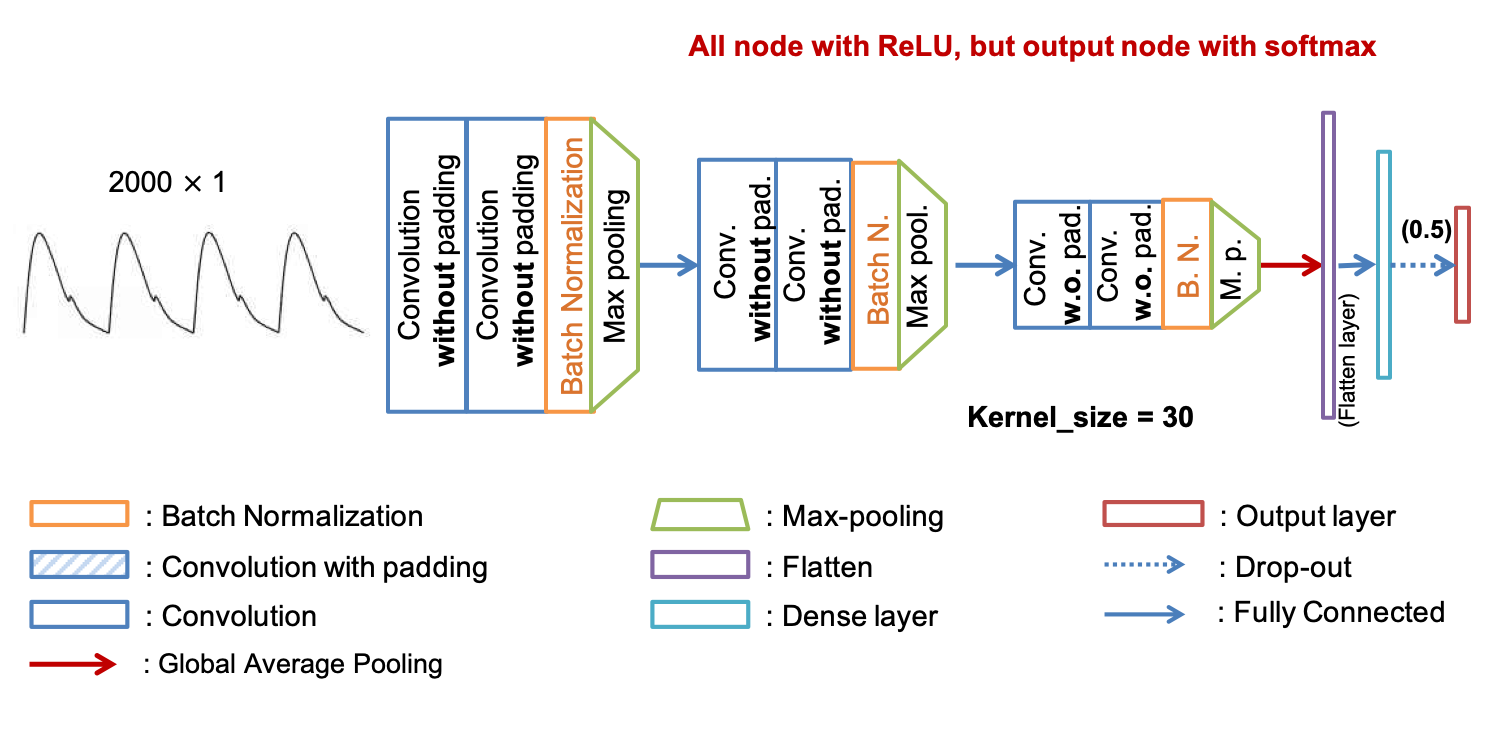

In [11]:
from IPython.display import Image
Image(filename="{}/kohi_CNN_model_archi.png".format(download_directory))

Keras를 이용한 CNN 구현 코드 (binary classification problem)

In [12]:
batch_size = 2000

inp = Input(shape=(aline_train.shape[1], 1))

#stem
x = Conv1D(filters=32, kernel_size=5, activation='relu')(inp)

# block 1
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(x)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([x, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 2
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 3
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 4
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 5
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 6
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

# block 7
fx = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(out)
fx = Conv1D(filters=32, kernel_size=5, padding='same')(fx)
out = Add()([out, fx])
out = ReLU()(out)
out = MaxPooling1D(pool_size=5, strides=2)(out)

### =========== Your code here ====================

# MLP Layers
out = Flatten()(out)
out = Dense(128, activation='relu')(out)
out = Dense(32, activation='relu')(out)
out = Dense(1, activation='sigmoid')(out)

### ===============================================

simple cnn model compile

In [13]:
### =========== Your code here ====================

simple_cnn_model = Model(inputs=[inp], outputs=[out])
adam_optimizer = tf.keras.optimizers.Adam(lr=0.0005)
simple_cnn_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

### ===============================================

In [14]:
simple_cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1996, 32)     192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1996, 32)     5152        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1996, 32)     5152        ['conv1d_1[0][0]']               
                                                                                              

### 모델 학습 파라미터 정의 및 학습 수행
`cache_path`: 모델이 저장될 경로 지정 <br>
`callback_functions`: 모델 학습에 사용되는 파라미터 설정 <br>

In [17]:
cache_path = os.path.join("/content/gdrive/My Drive", "simple_cnn_weight_lowbp.h5") # for colab
# cache_path = os.path.join(download_directory, "simple_cnn_weight_lowbp.h5") # for local

callback_functions = [ModelCheckpoint(monitor='val_loss', filepath=cache_path, verbose=1, save_best_only=True),
                      EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
                      ]

모델 학습 수행

In [18]:
### =========== Your code here ====================

simple_cnn_train_history = simple_cnn_model.fit(aline_train, ylabel_train, epochs = 10, 
                                                batch_size=batch_size, verbose=1, validation_split=0.2,
                                                callbacks=callback_functions)

### ===============================================

Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.7691
Epoch 1: val_loss improved from inf to 0.30788, saving model to /content/gdrive/My Drive/simple_cnn_weight_lowbp.h5
28/28 [==============================] - 9s 308ms/step - loss: 0.5362 - accuracy: 0.7691 - val_loss: 0.3079 - val_accuracy: 0.9126
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 0.4494 - accuracy: 0.7865
Epoch 2: val_loss improved from 0.30788 to 0.24863, saving model to /content/gdrive/My Drive/simple_cnn_weight_lowbp.h5
28/28 [==============================] - 9s 307ms/step - loss: 0.4494 - accuracy: 0.7865 - val_loss: 0.2486 - val_accuracy: 0.9197
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 0.4278 - accuracy: 0.7891
Epoch 3: val_loss did not improve from 0.24863
28/28 [==============================] - 8s 300ms/step - loss: 0.4278 - accuracy: 0.7891 - val_loss: 0.2605 - val_accuracy: 0.9058
Epoch 4/10
28/28 [========================

모델 학습 로그 plotting

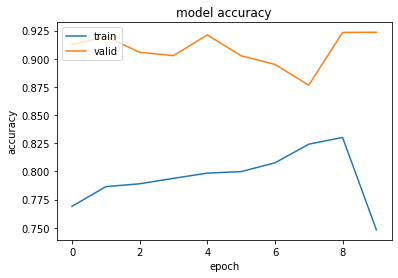

In [19]:
### =========== Your code here ====================

plt.plot(simple_cnn_train_history.history['accuracy'])
plt.plot(simple_cnn_train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

### ===============================================

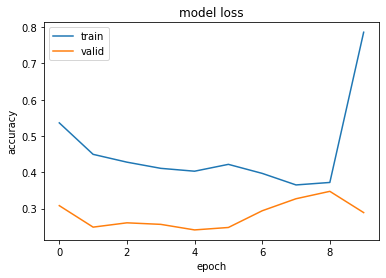

In [20]:
### =========== Your code here ====================

plt.plot(simple_cnn_train_history.history['loss'])
plt.plot(simple_cnn_train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

### ===============================================

학습 완료된 모델 (가장 성능이 우수했던 모델)을 불러와 testset에서 추론

In [21]:
simple_cnn_model.load_weights(cache_path)

In [22]:
simple_cnn_result = simple_cnn_model.predict(aline_test)

In [23]:
simple_cnn_result

array([[1.0311998e-02],
       [1.7827410e-02],
       [2.2858363e-02],
       ...,
       [5.1489426e-04],
       [4.9792021e-04],
       [8.0491576e-05]], dtype=float32)

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc, accuracy_score

`predict` 함수는 언제나 predicted probability를 return합니다. <br>
따라서 label을 원하면 반드시 한차례의 변환이 필요합니다.<br>
예를 들어 multi-class classification의 경우 `np.argmax(prediction, axis=1)`등의 형태로, 해당 instance에서 가장 높은 probability를 가지는 클래스를 할당해주어야 합니다. <br>
이 문제에서와 같이 binary classification의 경우, 해당 확률을 `threshold`를 이용해서 `0` or `1`의 클래스로 할당해줄 수 있습니다. <br>
보통의 경우 0.5를 기준으로 하여 threshold를 잡고, 정확도를 계산합니다.

In [25]:
simple_cnn_result_inclass = np.greater(simple_cnn_result, .5)

모델의 성능을 아래의 metric들을 통해 확인합니다.

precision = 모델이 True로 분류한 것 중 실제 True인 비율

$$ precision = {True\_positive \over True\_positive + False\_positive} $$

recall = 실제 Ture인 것 중에서 모델이 모델이 True라고 예측한 것의 비율

$$ recall = {True\_positive \over True\_positive + False\_negative} $$

F1 Score = Precision 과 Recall의 조화평균

$$ F1\_Score = 2 \times { precision \times recall \over precision + recall} $$

macro_avg = averaging the unweighted mean per label <br>
weighted_avg = averaging the support-weighted mean per label

In [26]:
print(classification_report(ylabel_test, simple_cnn_result_inclass, target_names=['normal', 'lowbp']))

              precision    recall  f1-score   support

      normal       0.82      1.00      0.90      9377
       lowbp       0.60      0.00      0.00      2126

    accuracy                           0.82     11503
   macro avg       0.71      0.50      0.45     11503
weighted avg       0.78      0.82      0.73     11503



roc curve를 plotting 합니다.

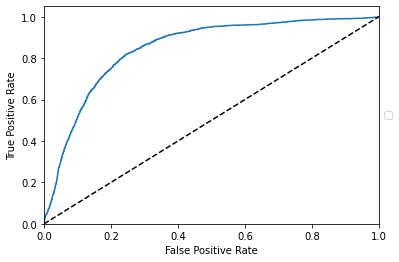

In [27]:
fpr, tpr, thresh = roc_curve(ylabel_test, simple_cnn_result)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

classification report 에서 lowbp class의 precision과 recall이 상당히 낮습니다. <br>
특히 recall이 낮다는 점은 모델이 전체적으로 0. class를 예측하려 하는 경향이 있다는 것을 보여줍니다. <br>
이 문제를 해결하기 위해 여러가지 방법론이 존재하지만, 여기선 가장 간단한 data engineering 적 접근을 시도해보겠습니다.


우리가 보유한 전체 데이터셋 (train and test)에서의 imbalancy를 살펴보면 다음과 같습니다.

In [28]:
# train set 에서
print(ylabel_train.sum() / len(ylabel_train))
# test set 에서
print(ylabel_test.sum() / len(ylabel_test))

0.1856234392241129
0.1848213509519256


위의 예제에서 validation set 에서의 imbalency를 살펴보면 다음과 같다.

In [29]:
ylabel_train[-int(len(ylabel_train)*.2):].sum() / int(len(ylabel_train) * .2)

0.07637023593466424

두 값이 크게 차이가 나는 것을 확인할 수 있습니다.<br>

이 이유는 keras에서 기본 제공하는 `valiation_split` 함수가 아래와 같이 holdout 하는 형태로 데이터셋을 구분하여 학습하기 때문입니다. <br> 따라서 데이터셋을 구축할 때 suffle을 해주지 않은 경우 (즉, 한 환자로부터 얻어진 데이터가 sequential하게 저장되어 있는 경우) validation 에 사용되는 환자의 데이터가 비교적 stable한 환자의 데이터일 수 있고, 이 경우에는 위의 사례와 같이 전체 데이터셋의 class 구성 비율과 다른 class 비율을 가지게 될 수 있으며, 이는 실제 현장에서 사용시 부정적인 영향을 미치게 됩니다.

In [30]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url='https://ichi.pro/assets/images/max/724/1*LDq5quSXhKhDETGrBKLjcQ.png')

따라서 dataset을 random 하게 새로 구분하여 validation set을 train set과 동일한 비율로 만들어서 학습시키는 것 만으로도 성능 향상을 기대할 수 있습니다.

In [31]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url='https://ichi.pro/assets/images/max/724/1*K3JLAHTGm2cVTfP5qIDFbg.png')

sklearn에서 제공하는 함수를 통해 데이터를 랜덤하게 분리해줍니다.

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(aline_train, ylabel_train, test_size=0.2, random_state=210904)

In [33]:
y_valid.sum() / len(y_valid)

0.18524970963995355

랜덤하게 분리된 train, valid 데이터셋을 가지고 학습을 수행합니다.<br>
모델 `fit`을 수행할 때 데이터를 명시적으로 지정해 줍니다.

In [36]:
new_cnn_model = Model(inputs=[inp], outputs=[out])
adam_optimizer = tf.keras.optimizers.Adam(lr=0.0005)
new_cnn_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

new_cache_path = os.path.join("/content/gdrive/My Drive", "new_cnn_weight_balanced.h5") # for colab

callback_functions = [ModelCheckpoint(monitor='val_loss', filepath=new_cache_path, verbose=1, save_best_only=True),
                      EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
                      ]
new_cnn_model_history = new_cnn_model.fit(X_train, y_train, epochs = 10, 
                                                batch_size=batch_size, verbose=1, validation_data=(X_valid, y_valid),
                                                callbacks=callback_functions)

Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.7916
Epoch 1: val_loss improved from inf to 0.40944, saving model to /content/gdrive/My Drive/new_cnn_weight_balanced.h5
28/28 [==============================] - 63s 324ms/step - loss: 0.6809 - accuracy: 0.7916 - val_loss: 0.4094 - val_accuracy: 0.8148
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.8156
Epoch 2: val_loss improved from 0.40944 to 0.38247, saving model to /content/gdrive/My Drive/new_cnn_weight_balanced.h5
28/28 [==============================] - 9s 307ms/step - loss: 0.3960 - accuracy: 0.8156 - val_loss: 0.3825 - val_accuracy: 0.8165
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 0.3859 - accuracy: 0.8171
Epoch 3: val_loss improved from 0.38247 to 0.37110, saving model to /content/gdrive/My Drive/new_cnn_weight_balanced.h5
28/28 [==============================] - 9s 322ms/step - loss: 0.3859 - accuracy: 0.8171 - val_loss

학습완료된 모델을 로드 및 testset 추론

In [37]:
new_cnn_model.load_weights(new_cache_path)

In [38]:
new_cnn_result = new_cnn_model.predict(aline_test)

In [39]:
new_cnn_result

array([[0.05908781],
       [0.05857245],
       [0.06812121],
       ...,
       [0.00368814],
       [0.0028496 ],
       [0.00124442]], dtype=float32)

In [40]:
new_cnn_result_inclass = np.greater(new_cnn_result, .5)

In [41]:
print(classification_report(ylabel_test, new_cnn_result_inclass, target_names=['normal', 'lowbp']))

              precision    recall  f1-score   support

      normal       0.82      0.96      0.89      9377
       lowbp       0.30      0.07      0.11      2126

    accuracy                           0.80     11503
   macro avg       0.56      0.52      0.50     11503
weighted avg       0.72      0.80      0.74     11503



roc curve plotting

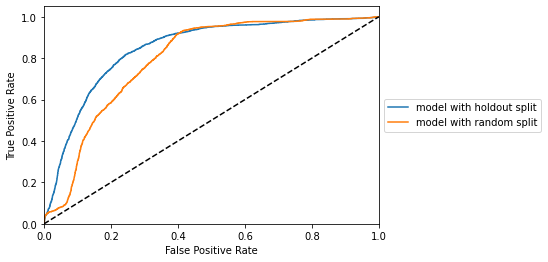

In [42]:
new_fpr, new_tpr, new_thresh = roc_curve(ylabel_test, new_cnn_result)
new_roc_auc = auc(new_fpr, new_tpr)


plt.plot(fpr, tpr, label='model with holdout split')
plt.plot(new_fpr, new_tpr, label='model with random split')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()